In [16]:
!pip install keras-tuner -q

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
import keras_tuner as kt
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import joblib
from google.colab import files

In [18]:
file_path = 'WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = pd.read_csv(file_path)

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [23]:
# 1. Clean TotalCharges (convert to numeric and handle errors)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
# Drop rows with missing values (only about 11 rows)
df.dropna(inplace=True)

# 2. Drop the customerID column (it's not useful for prediction)
df.drop('customerID', axis=1, inplace=True)

# 3. Encode Binary Categories (Yes/No, Male/Female)
# We'll use a simple loop to convert columns with only 2 unique values
le = LabelEncoder()
for col in df.columns:
    if df[col].dtype == 'object' and len(df[col].unique()) == 2:
        df[col] = le.fit_transform(df[col])

# 4. One-Hot Encoding for multi-category columns
# This creates new columns for things like 'InternetService' (DSL, Fiber, No)
df = pd.get_dummies(df)

# 5. Split data into Features (X) and Target (y)
X = df.drop('Churn', axis=1) # Everything except our target
y = df['Churn']              # Only the target

# 6. Split into Training set (80%) and Test set (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Feature Scaling (Crucial for Neural Networks!)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [24]:
print("Pre-processing Complete!")
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Pre-processing Complete!
Training data shape: (5625, 40)
Testing data shape: (1407, 40)


In [25]:
# 1. Initialize the ANN
model = Sequential()

# 2. Add the Input Layer and the first Hidden Layer
# 'units=16' means 16 neurons in this layer
# 'input_dim' tells the model how many features we have in X_train
model.add(Dense(units=16, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.2)) # Prevents overfitting

# 3. Add a second Hidden Layer
model.add(Dense(units=8, activation='relu'))
model.add(Dropout(0.2))

# 4. Add the Output Layer
# We use 'sigmoid' because we want a probability (0 to 1)
model.add(Dense(units=1, activation='sigmoid'))

# 5. Compiling the ANN
# 'adam' is the optimizer that updates the weights
# 'binary_crossentropy' is the standard loss function for Yes/No problems
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 6. Training the ANN on the Training set
# epochs=50 means the model will go through the entire dataset 50 times
# batch_size=32 means it looks at 32 customers at a time before updating itself
print("Starting training...")
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_split=0.2, verbose=1)

print("\nTraining Finished!")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Starting training...
Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5269 - loss: 0.7304 - val_accuracy: 0.7600 - val_loss: 0.4905
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7262 - loss: 0.5242 - val_accuracy: 0.7884 - val_loss: 0.4380
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7669 - loss: 0.4945 - val_accuracy: 0.8009 - val_loss: 0.4215
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7675 - loss: 0.4610 - val_accuracy: 0.8116 - val_loss: 0.4121
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7871 - loss: 0.4446 - val_accuracy: 0.8107 - val_loss: 0.4110
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7753 - loss: 0.4581 - val_accuracy: 0.8187 - val_loss: 0.4059
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7927 - loss: 0.4403 - val_accuracy: 0.8062 - val_loss: 0.4082
Epoch 8/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8051 - loss: 0.41

In [26]:
# 1. Calculate Class Weights
# This helps the model deal with the fact that there are fewer "Yes" (Churn" cases
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(weights))

# 2. Build a slightly deeper ANN
model = Sequential([
    Dense(32, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

# 3. Compile with Adam optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 4. Define Early Stopping
# If the 'val_loss' doesn't improve for 10 rounds, stop training to save the best version
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# 5. Train with class weights and early stopping
print("Starting Optimized Training...")
history = model.fit(
    X_train, y_train,
    epochs=100,             # Increased epochs, but early_stop will control it
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)

print("\nOptimized Training Finished!")

Starting Optimized Training...
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5565 - loss: 0.6668 - val_accuracy: 0.7120 - val_loss: 0.5664
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7096 - loss: 0.5518 - val_accuracy: 0.7396 - val_loss: 0.5062
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7258 - loss: 0.5217 - val_accuracy: 0.7324 - val_loss: 0.5125
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7283 - loss: 0.5081 - val_accuracy: 0.7396 - val_loss: 0.4965
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7239 - loss: 0.5145 - val_accuracy: 0.7582 - val_loss: 0.4718
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7409 - loss: 0.5014 - val_accuracy: 0.7591 - val_loss: 0.4668
Epoch 7/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7373 - loss: 0.5011 - val_accuracy: 0.7529 - val_loss: 0.4753
Epoch 8/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7454 - loss: 0.5046 - val_accuracy: 0.7591

In [28]:
!pip install keras-tuner -q

In [27]:
def build_model(hp):
    model = keras.Sequential()

    # Tune the number of layers
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(keras.layers.Dense(
            units=hp.Int(f'units_{i}', min_value=16, max_value=128, step=16),
            activation='relu'
        ))
        model.add(keras.layers.Dropout(hp.Float(f'dropout_{i}', 0.1, 0.5, step=0.1)))

    model.add(keras.layers.Dense(1, activation='sigmoid'))

    # Tune the learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Initialize the Tuner (RandomSearch is fast and effective)
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10, # It will try 10 different "recipes"
    executions_per_trial=1,
    directory='my_tuning_dir',
    project_name='churn_tuning'
)

print("Starting the Hyperparameter Search...")
tuner.search(X_train, y_train, epochs=20, validation_split=0.2, class_weight=class_weights, verbose=1)

# Get the best parameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete.
Optimal learning rate: {best_hps.get('learning_rate')}
Optimal number of layers: {best_hps.get('num_layers')}
""")

# Build the final model with the best parameters and train it
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, class_weight=class_weights, verbose=1)

Trial 10 Complete [00h 00m 13s]
val_accuracy: 0.7688888907432556

Best val_accuracy So Far: 0.8053333163261414
Total elapsed time: 00h 02m 33s

The hyperparameter search is complete.
Optimal learning rate: 0.01
Optimal number of layers: 2

Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6767 - loss: 0.6162 - val_accuracy: 0.7493 - val_loss: 0.4573
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7212 - loss: 0.5437 - val_accuracy: 0.7636 - val_loss: 0.4559
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6938 - loss: 0.5545 - val_accuracy: 0.7760 - val_loss: 0.4613
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7507 - loss: 0.5387 - val_accuracy: 0.7182 - val_loss: 0.4733
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7071 - loss: 0.5228 - val_accuracy: 0.6987 - val_loss: 0.4959
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6907 - loss: 0.5574 - val_accuracy: 0.7751 - val_loss:

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
--- Classification Report ---
              precision    recall  f1-score   support

           0       0.88      0.78      0.82      1033
           1       0.53      0.70      0.60       374

    accuracy                           0.75      1407
   macro avg       0.70      0.74      0.71      1407
weighted avg       0.78      0.75      0.76      1407



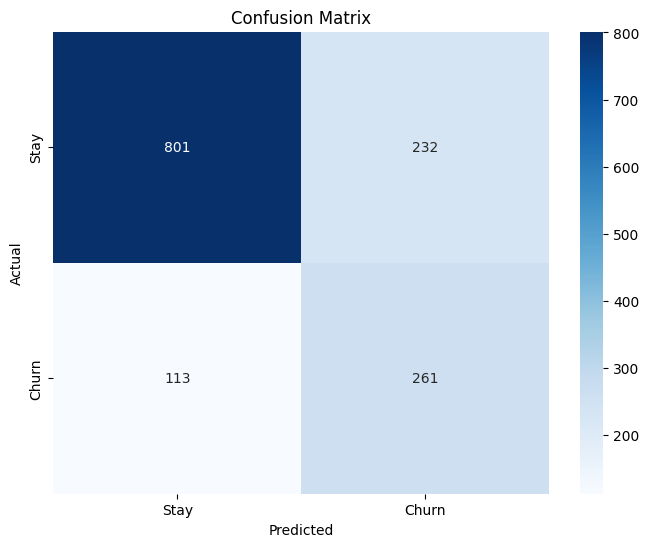

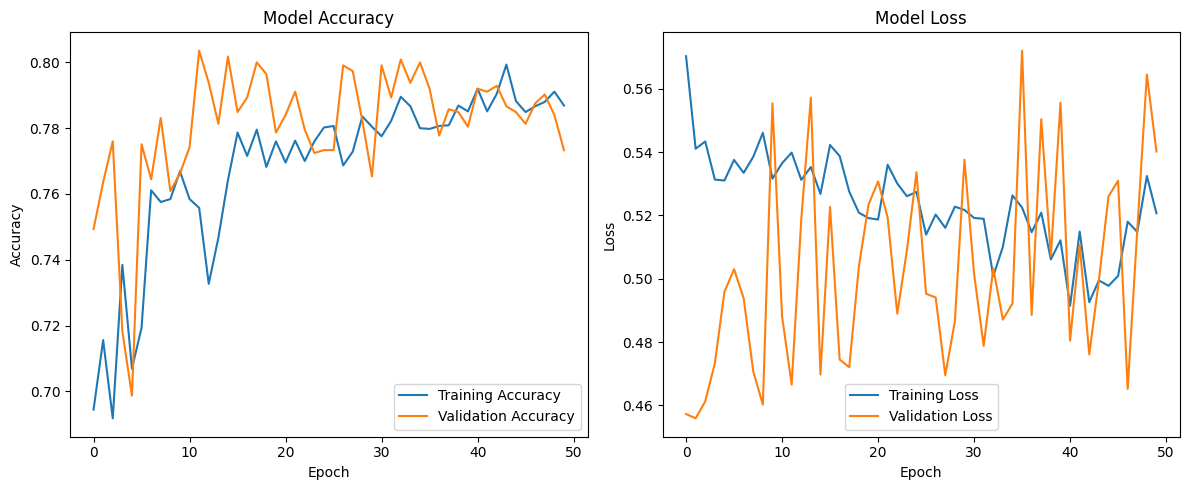

In [29]:
# 1. Make predictions on the Test Set
# The model gives probabilities (0.0 to 1.0), we convert them to 0 or 1
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# 2. Print Classification Report
print("--- Classification Report ---")
print(classification_report(y_test, y_pred))

# 3. Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Stay', 'Churn'], yticklabels=['Stay', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 4. Plot Training History (Loss and Accuracy)
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [30]:
# 1. Save the ANN Model
# We use the .keras format (standard for TensorFlow/Keras)
model.save('churn_model.keras')

# 2. Save the Scaler
# We use joblib because it's efficient for scaling parameters
joblib.dump(scaler, 'scaler.pkl')

print("Files saved successfully!")

# 3. Download the files to your local computer
# This will trigger two downloads in your browser
files.download('churn_model.keras')
files.download('scaler.pkl')

print("Downloads triggered. Keep these files safe for your future app!")

Files saved successfully!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloads triggered. Keep these files safe for your future app!
